# Vodafone Challenge
## Scrap notebook
- **Separate each test** you make with a markdown cell like this one (press M when the cursor is on a cell but it is not editing). 
- Put a **small description** on what you are doing and why you do so (like if you manipulate data in a specific way, or apply a particular definition of distance, write the intuition behind. Both for you to remmember later and for team members)
- Make sure you are working with the **proper data** i.e. the data (and their transformation) that you with to use are defined before you do the analysis. Bugs could appear if you do not define something and Python retrieves older values for the variables you are using.
- **Do not modify df_backup**, always work with a copy [like df = df_backup.copy()]
- Add short line of description in the Summary section
- For each test, write briefly which value of the parameter tried (like learning rate constant, tried eta0 large (10^-2) not well, smaller (10^-7) seem to work best. Then changed with learning rate adaptivive [which?] and tried ... large (10^-2) worked best).

**For the best test, build pipeline: bulleted version of all things done on the dataset until the result. It could be a useful thing to do for each test actually**

## Summary

1. **K-means on traffic data**: tested for different k's, both standardized and not. Performs poorly.
2. **preprocessing zip-urb** (Abetone, Montoro, Ginosa, Capannori, Vigo di Fassa, Scarpiera e San Piero)
3. **Perc imputation**

## Code
### *setup*

In [82]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.NaN)

In [83]:
df_backup = pd.read_csv('dataset_challenge_v5.TRAINING.csv')

### Cleaning
**DeviceOperatingSystem**: I preferred not to create a specific category for 'windows' because too few observations, however, if the 'other' category reveals to explain well, we can unpack it (in a new dataset)

In [84]:
df_clean = df_backup.copy()

del df_clean['Unnamed: 0']

c = list(df_clean.columns)
c[0] = 'ID'
df_clean.columns = c

df_clean['ZipCode'] = df_clean['ZipCode'].map(lambda x: '%05i' % x, na_action='ignore')

traffic_columns = ['File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications']
df_clean[traffic_columns]

cats = df_clean['CustomerAge'].astype('category').cat.categories
d = {cat:(15+10*i)/100 for i,cat in enumerate(cats)}
df_clean['NumericAge'] = df_clean['CustomerAge'].map(lambda x: d[x], na_action='ignore')

d = {}
for elem in df_clean['DeviceOperatingSystem']:
    d[elem] = d.get(elem, 0) + 1
print(d) #some categories have very few values, group them
OS_other = []
for key in d:
    if d[key] < 10:
        OS_other.append(key)
        d[key] = 'other'
    else:
        d[key] = key
df_clean['OS_clean'] = df_clean['DeviceOperatingSystem'].map(lambda x: d[x], na_action='ignore')

{'iOS': 568, nan: 548, 'Android': 858, 'Windows Mobile': 6, 'Proprietary': 5, 'Windows Phone': 7, 'BlackBerry OS': 1, 'Firefox': 1, 'Symbian^3': 1, 'BREW': 1, 'Series 40': 2, 'BB10': 1, 'VRTXmc': 1}


In [85]:
#Adding rural/urban information
df_zip_istat = pd.read_csv('databases/database.csv')
df_istat_urb = pd.read_csv('databases/it_postal_codes.csv/Foglio 2-Tabella 1.csv', error_bad_lines=False, sep = ';')
my_urb_dict = {'Basso' : 0, 'Medio' : 1, 'Elevato' : 2}
df_istat_urb['GradoUrbaniz'] = df_istat_urb['GradoUrbaniz'].map(lambda x: my_urb_dict[x], na_action = 'ignore')

#check there are no datapoint for which we don't have zip but we've region
df_clean['ZipCode'].isnull()
df_clean['Region'][df_clean['ZipCode'].isnull()]
len(df_clean['Region'][df_clean['ZipCode'].isnull()]) == np.sum(df_clean['Region'][df_clean['ZipCode'].isnull()].isnull())

#we need to insert x for multiple cap cities
isnan = lambda x: x != x
#nan is unique type not equal to itself, so with this lambda function we get True only when the type is NaN

for i in range(df_zip_istat.shape[0]):
    cap = df_zip_istat.loc[i, 'cap/0']
    cap  = '%05d' % cap
    if not isnan(df_zip_istat.loc[i,'cap/1']):
        if not isnan(df_zip_istat.loc[i,'cap/10']):   
            cap = cap[:-2]+'xx'
        else:
            cap = cap[:-1]+'x'
    df_zip_istat.loc[i, 'cap/0'] = cap

d_zip_istat = df_zip_istat.set_index('cap/0').to_dict()['codice']
d_istat_urb = df_istat_urb.set_index('ISTAT').to_dict()['GradoUrbaniz']

mask = df_clean['ZipCode'].isnull()
urban_col = np.zeros(df_clean.shape[0])
urban_col_masked = urban_col[~ mask]
d_zip_istat.update([('51021', 47023),( '83026', 64121),( '74025', 73007),( '55062', 46007),( '38039', 22217),('50037', 48053)])
d_istat_urb.update([(22250, 0),( 78157, 1)])

c = 0
for i in df_clean['ZipCode'][~ mask]:
    try:
        temp = d_zip_istat[i]
        urban_col_masked[c] = d_istat_urb[int(temp)]
    except KeyError:
        i = '%05d' % int(i)
        if i[:-1]+'x' in d_zip_istat:
            temp = d_zip_istat[i[:-1]+'x']
        elif i[:-2]+'xx' in d_zip_istat:
            temp = d_zip_istat[i[:-2]+'xx']
        else:
            raise()
    c += 1
    
df_clean['Urban'] = df_clean['ZipCode'].copy()
df_clean['Urban'][~ mask] = urban_col_masked

/Users/Renato/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Class definition and useful dependencies
Space that collects classes or function definition that come in handy throughtout the project

In [86]:
class buildTrain():
    def __init__(self, X, y, perc=0.8, std=False, pca=0, seed=None):
        if seed is not None:
            np.random.seed(seed)
        n_data, n_features = X.shape
        assert n_data == len(y)
        
        dopca = pca is None or pca > 0
        
        #check and remove nan values
        temp = X.copy()
        temp[y.name] = y.copy()
        temp.dropna(axis=0, how='any', inplace=True)
        
        if temp.shape[0] < n_data:
            print('Warning: missing data found and removed. Old input shape: %d, %d, new input shape: %d, %d'
                  % (X.shape[0], X.shape[1]+1, *temp.shape))
            X = temp
            y = temp[y.name]
            X.drop(y.name, axis=1, inplace=True)
            n_data, _ = X.shape
    
        assert n_data == len(y)
        
        perm = np.random.random(n_data)
        train_mask = perm < perc
        valid_mask = ~ train_mask
        
        train_data = X[train_mask]
        train_target = y[train_mask]
        valid_data = X[valid_mask]
        valid_target = y[valid_mask]
        assert (len(train_data)+len(valid_data)) == n_data
        
        if std:
            mean = train_data.mean(axis=0)
            std = train_data.std(axis=0) + 1e-10
            train_data = (train_data - mean) / std
            valid_data = (valid_data - mean) / std
            print('Performed standardization')
        
        if dopca:
            my_pca = PCA(n_components=pca)
            my_pca.fit(train_data)
            train_data = my_pca.transform(train_data)
            valid_data = my_pca.transform(valid_data)
            print('performed PCA, number of features: %d, explained variance for component:\n'%(my_pca.n_components_), 
                  ['%.2f'%i for i in my_pca.explained_variance_ratio_])
        
        self.Xt = train_data
        self.yt = train_target
        self.Xv = valid_data
        self.yv = valid_target
        
    def get_train(self):
        return self.Xt, self.yt
    
    def get_valid(self):
        return self.Xv, self.yv
    
    def get_size(self):
        return self.Xt.shape[0], self.Xv.shape[0]

In [87]:
class logger():
    def __init__(self, verbose = True):
        self.v = verbose
        self.log_ = []
        
    def log_it(self, text):
        #adds to log record
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        if self.v:
            print(text)
        self.log_.append(text)
        
    def print_out(self, text):
        if not isinstance(text, str):
            raise Exception('must pass text to logger')
        #doesn't add to log record
        if self.v:
            print(text)
        
    def show_img(self, array):
        if not isinstance(array, np.ndarray):
            raise Exception(1)
        if self.v:
            plt.imshow(array)
        
    def get_log(self):
        return "\n".join(self.log_)

In [88]:
def check_clusters(y, clust_labels, img_threshold=15, v=True):
    #checks input
    if y.ndim != 1: 
        raise Exception(2)
    if len(y) != len(clust_labels):
        raise Exception(4)
    
    #logger setup
    my_log = logger(verbose=v)
        
    #build histogram of categories (how many point for each cat)
    cats = {}
    for i in y:
        cats[i] = cats.get(i, 0) + 1
    n_cats = len(cats)
    
    #build histogram of clusters (how many point in each cluster)
    clusters = {}
    for i in clust_labels:
        clusters[i] = clusters.get(i, 0) + 1
    n_clusters = len(clusters)
        
    #create mapping from categories to index (to easily store data)
    #done because we assume y's values can be different from range(n_categories)
    #cat_list useful to quickly go back (header of result matrix)
    cat_map = {}
    cat_list = []
    for i, cat in enumerate(cats):
        cat_map[cat] = i
        cat_list.append(cat)
    
    #for each cluster, computes proportion of point belonging to each category
    result = np.zeros((n_clusters, n_cats))
    tot_per_clust = np.zeros((n_clusters,1), dtype=int)
    for i, clust in enumerate(clusters):
        labels = y[clust_labels == clust]
        tot_per_clust[i] = clusters[clust]
        for cat in labels:
            result[i,cat_map[cat]] += 1
            
    #to compute percentage of category points
    perc_cat = []
    for clust in range(len(result)):
        i_max = np.argmax(result[clust,:])
        tot = cats[cat_list[i_max]]
        perc_cat.append(result[clust, i_max] / tot * 100)
        
    #express each value as a proportion (normalization)
    result = result / tot_per_clust * 100
    
    #show graphical representation if matrix not too big
    if n_cats < img_threshold and n_clusters < img_threshold:
        my_log.show_img(result)
        
    #for each cluster show the category that fits it best
    for i,value in enumerate(np.argmax(result, axis=1)):
        #frequency of category: number of datapoint of a specific category belonging to that cluster
        #over the number of points in the cluster (variety within cluster)
        #category clustering: number of datapoint of a specific category belonging to that cluster,
        #over the total number of points of that category
        my_log.log_it('cluster: %s --> top category: %s, frequency of category (variety within cluster): %.2f%%, category clustering: %.2f%%'\
              % (i, cat_list[value], result[i, value], perc_cat[i]))
    score = np.sum(np.max(result, axis=1))/n_clusters
    weighted = np.dot(np.max(result, axis=1), np.array(perc_cat))/100
    #maybe it's best to weight the score by the category clustering index (see k-means example below)
    my_log.log_it("Overall score (doesn't consider category clustering): %.2f%%, weighted: %.2f%%"%(score, weighted))
    return weighted, my_log.get_log()

In [89]:
def standardize(df, column):
    if not isinstance(column, (str, int)):
        raise Exception(1)
    #returns a copy of the standardized column
    c = df[column].copy()
    mean = c.mean()
    sd = c.std()
    return (c - mean) / sd

In [90]:
def batch_std(df, columns):
    if not isinstance(columns, str):
        if len(columns) == 0:
            raise Exception('nto enough columns')
    else:
        raise Exception('must be an array or list')
    #returns a new dataframe with standardized columns
    new_df = pd.DataFrame()
    for column in columns:
        temp = standardize(df, column)
        new_df[column] = temp
    return new_df

In [91]:
class test():
    def __init__(self):
        self.best = [0,0,0]
        self.scores = []
        
    def update(self, score, k):
        score, log = score
        if score > self.best[0]:
            self.best = score, k, log
        self.scores.append((k, score))
        
    def get_result(self):
        best = self.best
        scores = self.scores
        print('best weighted score: %.2f%%, number of clusters: %i' % (best[0], best[1]))
        print('log of best: \n%s' % best[2])
        plt.figure()
        plt.plot(*zip(*scores),'-')

In [92]:
class interface():
    def __init__(self, seed = None, build_seed = None):
        if seed is None:
            seed = np.random.randint(666766)
        self.seed = seed
        self.build_seed = build_seed
            
    def train(self, X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=30, **args):
        np.random.seed(self.seed)
        self._check_balanced(y, threshold_unbalanced, args)
        _,_, valid = self._train(X, y, percentage, std, pca, epochs, args)
        if self.unbalanced:
            self._unbal_output(valid)
        self.train_param = (X, y, percentage, std, pca, epochs, args)
            
    def _check_balanced(self, y, threshold_unbalanced, args):
        unbalanced = False
        
        #check unbalanced dataset
        d_cat = {}
        clean_y = y[~y.isnull()]
        for i in clean_y:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
                    
        if max_num / len(clean_y) > threshold_unbalanced:
            print('Warning: found unbalanced dataset, training using balanced setting for class_weight')
            if 'class_weight' in args and args['class_weight'] is None:
                class_weight = {cat: 1/(d_cat[cat]/len(clean_y)) for cat in d_cat}
                args['class_weight'] = class_weight
                print('Weights used:', {i:float('%.2f'%d_cat[i]) for i in class_weight})
            unbalanced = True
        self.unbalanced = unbalanced
        
    def _train(self, X, y, percentage, std, pca, epochs, args):
        raise Exception('not implemented')
            
    def _unbal_output(self, valid):
        Xv, yv = valid
        obj = self.obj
        d_cat = {}
        for i in yv:
            d_cat[i] = d_cat.get(i, 0) + 1
        max_cat = 0
        max_num = 0
        for cat in d_cat:
            if d_cat[cat] > max_num:
                max_cat = cat
                max_num = d_cat[cat]
        mask = yv != max_cat
        if np.sum(mask) == 0:
            raise Exception('No data in smaller part of valid set')
        minority_score = obj.score(Xv[mask], yv[mask])
        majority_score = obj.score(Xv[~mask], yv[~mask])
        print('Score on smaller part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(mask)/len(yv)*100, minority_score))
        print('Score on bigger part (%.2f%%) of validation set (unbalanced case): %.2f' % 
              (np.sum(~mask)/len(yv)*100, majority_score))
        print('Category histogram in validation set:', d_cat)
            
   
        
    def test(self, n=10):
        best = np.zeros(n)
        worse = np.zeros(n)
        for i in range(n):
            np.random.seed(np.random.randint(10001)*i)
            tscores, vscores,_ = self._train(self.train_param)
            best[i] = np.max(vscores)
            worse[i] = np.min(vscores)
        print('average best performance: %.2f%%, standard deviation: %f'%(best.mean(), best.std()))
        plt.figure()
        plt.plot(np.arange(n), worse, color='r', label='worse performances')
        plt.plot(np.arange(n), best, color='g', label='best performances')
        legend = plt.legend(loc='upper center', shadow=True)
        plt.xlabel('samples')
        plt.ylabel('test score')
        plt.show()
        
    def predict(self, X, y):
        obj = self.obj
        mask = y.isnull()
        to_be_predicted = X[mask]
        assert y.shape[0] == X.shape[0]
        assert to_be_predicted.shape[0] != 0
        return obj.predict(to_be_predicted)

In [93]:
def train_perc_warm(perc, X, y, epochs, eta0, percentage, f_eta, std, pca, v, build_seed):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    n_features = data.get_train()[0].shape[1]
    n_classes = len(data.get_train()[1].unique())
    
    if n_classes == 1:
        raise Exception(1)
    if n_classes == 2:
        n_classes = 1
        
    coef = np.random.randn(n_classes, n_features) * 1e-2
    intercept = np.random.randn(n_classes) * 1e-2
    eta = eta0
    
    tscores = []
    vscores = []
    for epoch in range(epochs):
        perc.set_params(eta0=eta)
        perc.fit(*data.get_train(), coef_init = coef, intercept_init = intercept)
        tscore = perc.score(*data.get_train())
        vscore = perc.score(*data.get_valid())
        if v:
            print("run=%i tscore=%g vscore=%g" % (epoch+1, tscore, vscore))
        tscores.append(tscore)
        vscores.append(vscore)
        coef, intercept = perc.coef_, perc.intercept_
        eta = f_eta(eta0, epoch)
    if v:
        plt.figure()
        plt.plot(np.arange(epochs), tscores, np.arange(epochs), vscores)
        
    return tscores, vscores, data.get_valid()

In [94]:
def train_perc_cold(perc, X, y, percentage, max_iter, std, pca, build_seed):
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    perc.set_params(max_iter=max_iter)
    perc.fit(*data.get_train())
    tscore = perc.score(*data.get_train())
    vscore = perc.score(*data.get_valid())
    print("tscore=%g vscore=%g" % (tscore, vscore))
        
    return tscore, vscore, data.get_valid()

In [95]:
class perc(interface):
    
    def _train(self, X, y, percentage, std, pca, epochs, args):
        warm_start = True
        learning_rate = args.get('learning_rate', 'optimal')
        it_interval = args.pop('it_interval', 100)
        power_t = args.get('power_t', 0.5)
        #check learning_rate
        if learning_rate == 'constant':
            f_eta = lambda eta0, epoch: eta0
        elif learning_rate == 'invscaling':
            f_eta = lambda eta0, epoch: eta0 / ((epoch + 1) * it_interval)**power_t
        elif learning_rate == 'optimal':
            warm_start = False
            f_eta = None
        else:
            raise Exception('not valid value')                
            
        #compute max_iter
        max_iter = epochs * it_interval
        args['max_iter'] = it_interval
            
        #create multiple perceptron
        perc_ = SGDClassifier(**args)

        param_warm = (perc_, X, y, epochs, args['eta0'], percentage, f_eta, std, pca, True, self.build_seed)
        param_cold = (perc_, X, y, percentage, max_iter, std, pca, self.build_seed)
        
        #perform analysis
        if warm_start:
            tscores, vscores, valid = train_perc_warm(*param_warm)
        else:
            tscores, vscores, valid = train_perc_cold(*param_cold)
            
        self.obj = perc_
        return tscores, vscores, valid
    
    def __str__(self):
        return 'Perceptron interface'

In [96]:
def train_MLP(ml_perc, X, y, percentage=0.8, max_iter= 30, std=False, pca=0, v=True, build_seed=None):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)
    
    tscores = []
    vscores = []
    for epoch in range(max_iter):
        ml_perc.set_params(max_iter=epoch+1)
        ml_perc.fit(*data.get_train())
        tscore = ml_perc.score(*data.get_train())
        vscore = ml_perc.score(*data.get_valid())
        loss = ml_perc.loss_
        if v:
            print(f"epoch={epoch} loss={loss} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        ml_perc.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores, data.get_valid()

In [97]:
class MLP(interface):
    
    def _train(self, X, y, percentage, std, pca, epochs, args):             
            
        #create multiple perceptron
        ml_perc_ = MLPClassifier(**args)
        
        param_warm = (ml_perc_, X, y, percentage, epochs, std, pca, True, self.build_seed)
        
        tscores, vscores, valid = train_MLP(*param_warm)
        
        #save settings
        self.obj = ml_perc_
        return tscores, vscores, valid
    
    def __str__(self):
        return 'MLP interface'

In [98]:
def train_LR(log_reg, X, y, percentage=0.8, max_iter= 30, std=False, pca=0, v=True, build_seed=None):
    
    data = buildTrain(X, y, percentage, std, pca, seed=build_seed)

    tscores = []
    vscores = []
    for epoch in range(max_iter):
        log_reg.set_params(max_iter=epoch+1)
        log_reg.fit(*data.get_train())
        tscore = log_reg.score(*data.get_train())
        vscore = log_reg.score(*data.get_valid())
        if v:
            print(f"epoch={epoch} tscore={tscore} vscore={vscore}")
        tscores.append(tscore)
        vscores.append(vscore)
        log_reg.set_params(warm_start=True)
        
    if v:
        plt.figure()
        plt.plot(np.arange(max_iter), tscores, np.arange(max_iter), vscores)
    
    return tscores, vscores, data.get_valid()

In [99]:
class LogReg(interface):
    
    #penalty=’l2’, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
    #class_weight=None, random_state=None, solver=’liblinear’, max_iter=100, multi_class=’ovr’, 
    #verbose=0, warm_start=False, n_jobs=1
    #solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’},
    #default: ‘liblinear’ Algorithm to use in the optimization problem.
    #For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
    #For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
    #handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
    #‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.
    
    #Multiclass option can be either ‘ovr’ or ‘multinomial’. If the option chosen is ‘ovr’, then a binary problem 
    #is fit for each label. Else the loss minimised is the multinomial loss fit across the entire probability distribution. 
    #Does not work for liblinear solver.

         
    def _train(self, X, y, percentage, std, pca, epochs, args):            
        
        #create logistic regression
        log_regr_ = LogisticRegression(**args)
        
        param_warm = (log_regr_, X, y, percentage, epochs, std, pca, True, self.build_seed)
        
        tscores, vscores, valid = train_LR(*param_warm)
        
        #save settings
        self.obj = log_regr_
        return tscores, vscores, valid
    def __str__(self):
        return 'Logistic Regression interface'

In [100]:
def test_sup(X, y, *objs):
    assert X.shape[0] == len(y)
    scores = np.zeros(len(objs))
    c = 0
    plt.figure()
    for obj in objs:
        if not isinstance(obj, interface):
            raise Exception('must pass interface subclass object')
        print(X.shape, y.shape)
        score = obj.obj.score(X, y)
        print(score)
        scores[c] = score
        print(scores)
        c += 1
        print(c)
        plt.plot(c, score, '.', label=str(obj))
    legend = plt.legend(loc=(1.01, 0), shadow=True)
    plt.show()
    i_max = np.argmax(scores)
    print('best is %s with score %.2f' % (str(objs[i_max]), scores[i_max]))

## Questions
1. How can we decide which approach to prefer between substituting with the mean of the column and using a trained supervised (with a certain accuracy), in the case of missing values?
2. How do we optimize parameters in unbalanced dataset? Because for us we can go over 50% on big and small dataset
4. What can we do if dataset unbalanced and we are using MLP?

## Next Steps
1. Train MLP (build interface if needed, should be needed)
2. Predict age wrt traffic data for filling in the data
3. Predict os wrt traffic data for filling in the data
4. Predict urbaniz wrt traffic data for filling in the data
5. Predict data allowance wrt traffic data for filling in the data
6. Monthly data traffic
7. others
8. clusteringggg

## Tests

### K-means on traffic
Just an exploratory study, let's see what we get...

In [ ]:
from sklearn.cluster import KMeans

X = df_clean[traffic_columns]
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X)
score = check_clusters(y=y, clust_labels=km.labels_)

now we try the same but with standardized columns, see the difference

In [ ]:
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

km = KMeans(n_clusters=6, init='k-means++', n_init=10, n_jobs=4)
km.fit(X_std)
score = check_clusters(y=y, clust_labels=km.labels_)

It seems to have improved. Still the clusters seem to separate pretty poorly. Let's see the optimal value of k based on our previous score (using standardized data which seem to make more sense). We set the same seed each time so that the results are comparable and not influenced by different initial centroid allocation.

In [ ]:
my_test = test()

np.random.seed(23453)
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 10):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, n_jobs=4)
    km.fit(X_std)
    
    score= check_clusters(y=y, clust_labels=km.labels_, v=False)
    my_test.update(score, k)
        
my_test.get_result()

### Hierarchical clustering on traffic data
Same approach as for k-means, test difference between standardized and not.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='ward', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

try complete linkage

In [ ]:
from sklearn.cluster import AgglomerativeClustering

my_test = test()
X_std = batch_std(df_clean, traffic_columns)
y = df_clean['Product']

for k in range(2, 8):
    clust = AgglomerativeClustering(n_clusters=k, linkage='complete', affinity='euclidean')
    clust.fit(X_std)
    score = check_clusters(y=y, clust_labels=clust.labels_, v=False)
    my_test.update(score, k)

my_test.get_result()

### Perceptron (imputation of age data with traffic data)

First of all we try to build a Perceptron to complete the age column keeping all the categories.

In [ ]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['NumericAge'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
print(dict_numage_to_agecat)
df["NumericAge"] = df["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df[traffic_columns]
y = df['NumericAge']
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

In [ ]:
my_perc.predict(X,y)

In [ ]:
df = df_clean.copy()
#df.dropna(axis=0, how='any', subset=['Urban'], inplace=True)

#merge some age ranges together
#dict_numage_to_agecat = {i : int(100*i//40) for i in df["NumericAge"].unique()}
X = df[traffic_columns]
#unbalanced?
#np.bincount(y[~np.isnan(y)].astype(int))
y = df['Urban'].map(lambda x: int(x), na_action = 'ignore')
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None))

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]

y = df['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
print(y.unique())
my_perc = perc()

In [ ]:
my_perc.train(X, y, percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', penalty='none', alpha=1e-6,
          power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
          class_weight=None)

### MLP

In [ ]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_MLP = MLP()

In [ ]:
my_MLP.train(X, y, percentage=0.8, std=True, pca=None, threshold_unbalanced=0.6, epochs=50,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-1, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.0, nesterovs_momentum = False,
             alpha = 0.0, tol = -1)

In [ ]:
my_MLP.predict(X,y)

In [ ]:
a = df_clean['OS_clean'].copy()
d = dict()
for i in a:
    d[i] = d.get(i, 0) + 1
d

# Logistic Regression

In [20]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
my_lr = LogReg()

Performed standardization
performed PCA, number of features: 13, explained variance for component:
 ['0.13', '0.10', '0.10', '0.08', '0.08', '0.08', '0.08', '0.07', '0.07', '0.07', '0.07', '0.06', '0.00']
epoch=0 tscore=0.6464560204953032 vscore=0.6014234875444839
epoch=1 tscore=0.6660973526900086 vscore=0.6120996441281139


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increas

epoch=2 tscore=0.7284372331340735 vscore=0.701067615658363
epoch=3 tscore=0.7386848847139197 vscore=0.708185053380783
epoch=4 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=5 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=6 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=7 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=8 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=9 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=10 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=11 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=12 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=13 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=14 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=15 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=16 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=17 tscore=0.7378309137489325 vscore=0.708185053380783
epoch=18 tscore=0.7378309137489325 vscore=0.7081

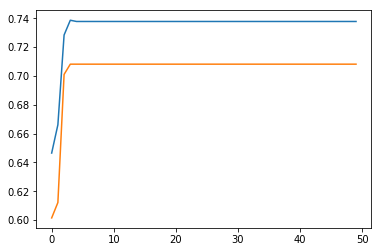

In [21]:
my_lr.train(X, y, percentage=0.8, std=True, pca=None, threshold_unbalanced=0.6, epochs=50,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

## Data imputation taken seriously
### OS

In [101]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['OS_clean']
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 456245
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1227, test size 225


run=1 tscore=0.349028 vscore=0.296
run=2 tscore=0.392016 vscore=0.344
run=3 tscore=0.450358 vscore=0.412
run=4 tscore=0.509724 vscore=0.484
run=5 tscore=0.544524 vscore=0.536
run=6 tscore=0.561924 vscore=0.54
run=7 tscore=0.568066 vscore=0.54
run=8 tscore=0.573183 vscore=0.552
run=9 tscore=0.576254 vscore=0.556
run=10 tscore=0.578301 vscore=0.56
run=11 tscore=0.584442 vscore=0.564
run=12 tscore=0.585466 vscore=0.568
run=13 tscore=0.585466 vscore=0.568
run=14 tscore=0.585466 vscore=0.568
run=15 tscore=0.586489 vscore=0.572
run=16 tscore=0.586489 vscore=0.572
run=17 tscore=0.588536 vscore=0.572
run=18 tscore=0.588536 vscore=0.572
run=19 tscore=0.588536 vscore=0.572
run=20 tscore=0.588536 vscore=0.572
run=21 tscore=0.588536 vscore=0.572
run=22 tscore=0.588536 vscore=0.572
run=23 tscore=0.58956 vscore=0.572
run=24 tscore=0.58956 vscore=0.572
run=25 tscore=0.58956 vscore=0.572
run=26 tscore=0.58956 vscore=0.572
run=27 tscore=0.58956 vscore=0.572
run=28 tscore=0.58956 vscore=0.572
run=29 tsc

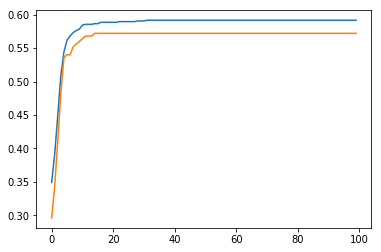

In [102]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,  loss='log', 
              penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight=None)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=0.8157545295990897 tscore=0.6049129989764586 vscore=0.576
epoch=1 loss=0.7514260999960133 tscore=0.6151484135107472 vscore=0.58
epoch=2 loss=0.7311216977038787 tscore=0.6182190378710338 vscore=0.6
epoch=3 loss=0.708621238723979 tscore=0.6827021494370522 vscore=0.668
epoch=4 loss=0.7042671250704473 tscore=0.691914022517912 vscore=0.672
epoch=5 loss=0.6924963959982076 tscore=0.631525076765609 vscore=0.604
epoch=6 loss=0.6831110981094424 tscore=0.7113613101330604 vscore=0.684
epoch=7 loss=0.6737171616993263 tscore=0.6509723643807575 vscore=0.604
epoch=8 loss=0.6794553771030308 tscore=0.6345957011258956 vscore=0.604
epoch=9 loss=0.6523053063685571 tscore=0.6908904810644831 vscore=0.672
epoch=10 loss=0.6418881882208883 tscore=0.7615148413510747 vscore=0.748
epoch=11 loss=0.6353817873562094 tscore=0.7666325486182191 vscore=0.732
epoch=12 loss=0.6283903838481288 tscore=0.7727737973387923 vscore=0.776
epoch=13 loss=0.6059048595129182 tscore=0.7717502558853634 vscore=0.768
epoch=14

epoch=118 loss=0.3986239409160539 tscore=0.8802456499488229 vscore=0.82
epoch=119 loss=0.38272610445486704 tscore=0.8986693961105425 vscore=0.848
epoch=120 loss=0.37971998289922887 tscore=0.9007164790174002 vscore=0.828
epoch=121 loss=0.3794076878508488 tscore=0.8915046059365405 vscore=0.828
epoch=122 loss=0.37900044838139274 tscore=0.8986693961105425 vscore=0.812
epoch=123 loss=0.37547344331024973 tscore=0.9037871033776868 vscore=0.852
epoch=124 loss=0.3847018092200704 tscore=0.8925281473899693 vscore=0.832
epoch=125 loss=0.3783113183391287 tscore=0.8822927328556807 vscore=0.812
epoch=126 loss=0.3893115392138178 tscore=0.8761514841351075 vscore=0.84
epoch=127 loss=0.3874122353517281 tscore=0.9058341862845445 vscore=0.832
epoch=128 loss=0.3813433799820466 tscore=0.8812691914022518 vscore=0.824
epoch=129 loss=0.37941082782500923 tscore=0.8986693961105425 vscore=0.82
epoch=130 loss=0.3752844218532252 tscore=0.9089048106448311 vscore=0.848
epoch=131 loss=0.37707040578398293 tscore=0.90583

epoch=231 loss=0.3557714514052986 tscore=0.9129989764585466 vscore=0.84
epoch=232 loss=0.36151742186423635 tscore=0.8812691914022518 vscore=0.8
epoch=233 loss=0.3652209827110768 tscore=0.887410440122825 vscore=0.796
epoch=234 loss=0.3749391661220059 tscore=0.9201637666325486 vscore=0.856
epoch=235 loss=0.36655043455464925 tscore=0.9119754350051177 vscore=0.86
epoch=236 loss=0.3626312489844122 tscore=0.9078812691914022 vscore=0.824
epoch=237 loss=0.3650833109664719 tscore=0.9150460593654043 vscore=0.852
epoch=238 loss=0.36485391034396003 tscore=0.9119754350051177 vscore=0.852
epoch=239 loss=0.35585163571967693 tscore=0.9150460593654043 vscore=0.848
epoch=240 loss=0.3602278209740593 tscore=0.8822927328556807 vscore=0.812
epoch=241 loss=0.3745860875571651 tscore=0.9058341862845445 vscore=0.804
epoch=242 loss=0.3599727411897059 tscore=0.8812691914022518 vscore=0.816
epoch=243 loss=0.374747492919884 tscore=0.9089048106448311 vscore=0.808
epoch=244 loss=0.3794221707632999 tscore=0.9099283520

epoch=345 loss=0.3630952695451721 tscore=0.9191402251791198 vscore=0.86
epoch=346 loss=0.3518379073742143 tscore=0.9201637666325486 vscore=0.848
epoch=347 loss=0.3571097555392905 tscore=0.9191402251791198 vscore=0.856
epoch=348 loss=0.3531055679397392 tscore=0.9160696008188332 vscore=0.852
epoch=349 loss=0.3590099822514903 tscore=0.9109518935516888 vscore=0.832
epoch=350 loss=0.3542875694476104 tscore=0.9191402251791198 vscore=0.836
epoch=351 loss=0.35087619386646146 tscore=0.8884339815762539 vscore=0.808
epoch=352 loss=0.3663333457758305 tscore=0.8894575230296827 vscore=0.828
epoch=353 loss=0.3677790527117742 tscore=0.9160696008188332 vscore=0.828
epoch=354 loss=0.3669624071394392 tscore=0.9140225179119754 vscore=0.864
epoch=355 loss=0.3610651427040784 tscore=0.9211873080859775 vscore=0.852
epoch=356 loss=0.36732453442447255 tscore=0.9037871033776868 vscore=0.808
epoch=357 loss=0.35285851306107197 tscore=0.9160696008188332 vscore=0.832
epoch=358 loss=0.3505734334509023 tscore=0.921187

epoch=464 loss=0.3567909624959846 tscore=0.9222108495394064 vscore=0.856
epoch=465 loss=0.3537481819271413 tscore=0.9222108495394064 vscore=0.86
epoch=466 loss=0.3669465635727644 tscore=0.9211873080859775 vscore=0.856
epoch=467 loss=0.34408362492265054 tscore=0.9089048106448311 vscore=0.828
epoch=468 loss=0.3496880147577068 tscore=0.8945752302968271 vscore=0.812
epoch=469 loss=0.37085597881307286 tscore=0.8935516888433982 vscore=0.792
epoch=470 loss=0.3758836308361523 tscore=0.8996929375639714 vscore=0.812
epoch=471 loss=0.35430234148999995 tscore=0.9181166837256909 vscore=0.856
epoch=472 loss=0.35050607354388075 tscore=0.9263050153531218 vscore=0.86
epoch=473 loss=0.35226034010071344 tscore=0.9181166837256909 vscore=0.844
epoch=474 loss=0.3486636871778783 tscore=0.8986693961105425 vscore=0.82
epoch=475 loss=0.35431289173763386 tscore=0.9027635619242579 vscore=0.816
epoch=476 loss=0.37387239434561703 tscore=0.9058341862845445 vscore=0.824
epoch=477 loss=0.35761844994339254 tscore=0.912

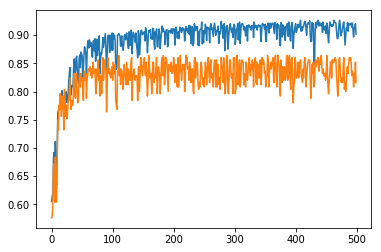

In [103]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=0 tscore=0.5916069600818833 vscore=0.572
epoch=1 tscore=0.5916069600818833 vscore=0.572
epoch=2 tscore=0.6110542476970318 vscore=0.592
epoch=3 tscore=0.6120777891504606 vscore=0.592
epoch=4 tscore=0.6120777891504606 vscore=0.592
epoch=5 tscore=0.6120777891504606 vscore=0.592
epoch=6 tscore=0.6120777891504606 vscore=0.592
epoch=7 tscore=0.6120777891504606 vscore=0.592
epoch=8 tscore=0.6120777891504606 vscore=0.592
epoch=9 tscore=0.6120777891504606 vscore=0.592
epoch=10 tscore=0.6120777891504606 vscore=0.592
epoch=11 tscore=0.6120777891504606 vscore=0.592
epoch=12 tscore=0.6120777891504606 vscore=0.592
epoch=13 tscore=0.6120777891504606 vscore=0.592
epoch=14 tscore=0.6120777891504606 vscore=0.592
epoch=15 tscore=0.6120777891504606 vscore=0.592
epoch=16 tscore=0.6120777891504606 vscore=0.592
epoch=17 tscore=0.6120777891504606 vscore=0.592
epoch=18 tscore=0.6120777891504606 vscore=0.592
epoch=19 tscore=0.6120777891504606 vscore=0.592
epoch=20 tscore=0.6120777891504606 vscore=0.592
ep

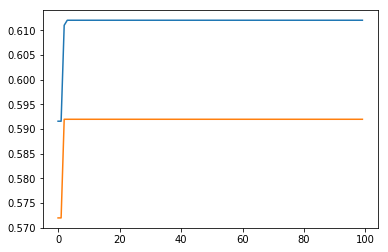

In [104]:
my_lr.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(225, 13) (225,)
0.6133333333333333
[0.61333333 0.         0.        ]
1
(225, 13) (225,)
0.8977777777777778
[0.61333333 0.89777778 0.        ]
2
(225, 13) (225,)
0.6088888888888889
[0.61333333 0.89777778 0.60888889]
3


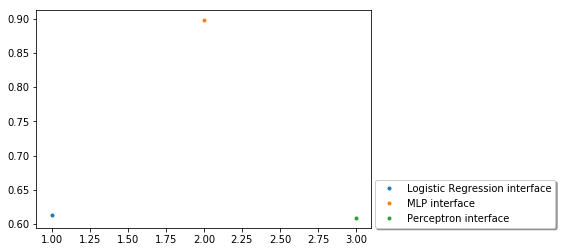

best is MLP interface with score 0.90


In [105]:
test_sup(*data.get_valid(), my_lr, my_MLP, my_perc)

Therefore we use this MLP to predict the rest of the column OS and keep the predictions to imput into our dataset later.

In [70]:
os_missing = my_MLP.predict(X,y)

# Urbanization

In [106]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['Urban'].map(lambda x: int(x), na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1423, test size 231


run=1 tscore=0.398757 vscore=0.478114
run=2 tscore=0.40675 vscore=0.474747
run=3 tscore=0.407638 vscore=0.478114
run=4 tscore=0.409414 vscore=0.474747
run=5 tscore=0.405861 vscore=0.488215
run=6 tscore=0.408526 vscore=0.488215
run=7 tscore=0.41119 vscore=0.488215
run=8 tscore=0.412966 vscore=0.488215
run=9 tscore=0.413854 vscore=0.488215
run=10 tscore=0.417407 vscore=0.488215
run=11 tscore=0.418295 vscore=0.488215
run=12 tscore=0.418295 vscore=0.484848
run=13 tscore=0.419183 vscore=0.488215
run=14 tscore=0.420959 vscore=0.481481
run=15 tscore=0.421847 vscore=0.484848
run=16 tscore=0.420071 vscore=0.484848
run=17 tscore=0.420071 vscore=0.484848
run=18 tscore=0.417407 vscore=0.488215
run=19 tscore=0.416519 vscore=0.488215
run=20 tscore=0.416519 vscore=0.488215
run=21 tscore=0.416519 vscore=0.488215
run=22 tscore=0.415631 vscore=0.488215
run=23 tscore=0.415631 vscore=0.484848
run=24 tscore=0.415631 vscore=0.484848
run=25 tscore=0.416519 vscore=0.484848
run=26 tscore=0.418295 vscore=0.4848

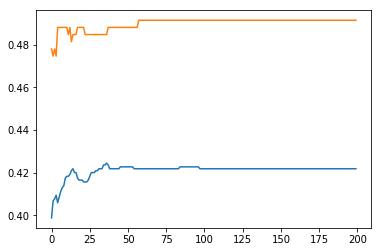

In [107]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=200,  loss='squared_hinge', 
              penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', eta0=1e-8,
              class_weight=None)

epoch=0 loss=1.1419261659298412 tscore=0.29396092362344584 vscore=0.31313131313131315
epoch=1 loss=1.1327116075062216 tscore=0.3756660746003552 vscore=0.45791245791245794
epoch=2 loss=1.125227647810898 tscore=0.4191829484902309 vscore=0.4882154882154882
epoch=3 loss=1.118979394542578 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=4 loss=1.1138783425059005 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=5 loss=1.1099116288554587 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=6 loss=1.1062658305621007 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=7 loss=1.1035960226346444 tscore=0.4218472468916519 vscore=0.49158249158249157


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=8 loss=1.1013358021342736 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=9 loss=1.099544745508655 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=10 loss=1.0980009886229805 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=11 loss=1.096827518787419 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=12 loss=1.095585989149606 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=13 loss=1.0946133353999927 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=14 loss=1.0937591197880314 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=15 loss=1.0929611012594567 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=16 loss=1.0923164512336094 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=17 loss=1.0916132834491303 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=18 loss=1.0910336788006412 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=19 loss=1.0904802275093968 tscore=0.4218472468916519 

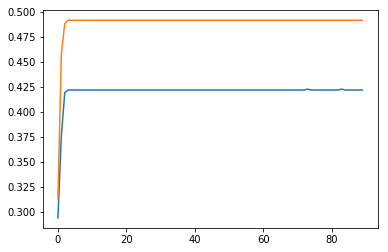

In [108]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=90,
             hidden_layer_sizes = (200,), batch_size = 50, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.10, tol = 1e-4)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=0 tscore=0.4218472468916519 vscore=0.49158249158249157
epoch=1 tscore=0.42095914742451157 vscore=0.48148148148148145
epoch=2 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=3 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=4 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=5 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=6 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=7 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=8 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=9 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=10 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=11 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=12 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=13 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=14 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=15 tscore=0.42628774422735344 vscore=0.4882154882154882
epoch=16 tscore=0

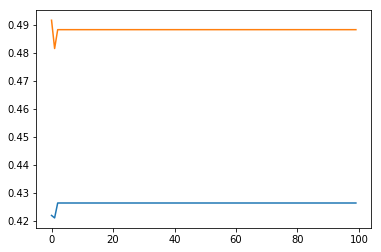

In [109]:
my_lr.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(231, 13) (231,)
0.44155844155844154
[0.44155844 0.         0.        ]
1
(231, 13) (231,)
0.42424242424242425
[0.44155844 0.42424242 0.        ]
2
(231, 13) (231,)
0.42424242424242425
[0.44155844 0.42424242 0.42424242]
3


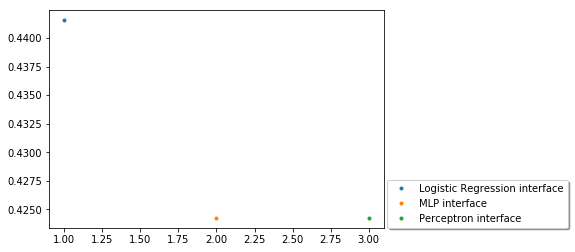

best is Logistic Regression interface with score 0.44


In [110]:
test_sup(*data.get_valid(), my_lr, my_MLP, my_perc)

# Numeric Age

In [111]:
df = df_clean.copy()

dict_numage_to_agecat = {0.85: 2, 0.65: 1, 0.35: 0, 0.75: 1, 0.55: 1, 0.45: 1, 0.25: 0, 0.15: 0}
df["NumericAge"] = df["NumericAge"].map(lambda x: dict_numage_to_agecat[x], na_action = 'ignore')
X = df[traffic_columns]
y = df['NumericAge']
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 456222
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1591, test size 289


Weights used: {2.0: 4.0, 1.0: 1030.0, 0.0: 557.0}
run=1 tscore=0.650706 vscore=0.634069
run=2 tscore=0.650706 vscore=0.634069
run=3 tscore=0.650706 vscore=0.634069
run=4 tscore=0.650706 vscore=0.634069
run=5 tscore=0.650706 vscore=0.634069
run=6 tscore=0.650706 vscore=0.634069
run=7 tscore=0.650706 vscore=0.637224
run=8 tscore=0.649922 vscore=0.637224
run=9 tscore=0.645997 vscore=0.634069
run=10 tscore=0.646782 vscore=0.637224
run=11 tscore=0.647567 vscore=0.640379
run=12 tscore=0.645212 vscore=0.640379
run=13 tscore=0.644427 vscore=0.640379
run=14 tscore=0.642857 vscore=0.643533
run=15 tscore=0.645212 vscore=0.643533
run=16 tscore=0.645212 vscore=0.643533
run=17 tscore=0.643642 vscore=0.646688
run=18 tscore=0.645212 vscore=0.646688
run=19 tscore=0.646782 vscore=0.646688
run=20 tscore=0.646782 vscore=0.646688
run=21 tscore=0.646782 vscore=0.646688
run=22 tscore=0.645997 vscore=0.646688
run=23 tscore=0.649922 vscore=0.649842
run=24 tscore=0.649922 vscore=0.652997
run=25 tscore=0.650706 

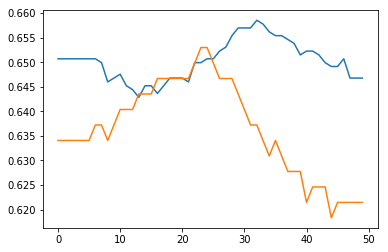

In [112]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='constant', 
              eta0=1e-4, class_weight=None)

epoch=0 loss=0.7981758474246925 tscore=0.6208791208791209 vscore=0.6403785488958991
epoch=1 loss=0.6619147262363186 tscore=0.6546310832025117 vscore=0.637223974763407
epoch=2 loss=0.6577452930130014 tscore=0.6554160125588697 vscore=0.6435331230283912
epoch=3 loss=0.6315373516182389 tscore=0.6562009419152276 vscore=0.6403785488958991
epoch=4 loss=0.6302602349946111 tscore=0.6569858712715856 vscore=0.6403785488958991
epoch=5 loss=0.6270801366196361 tscore=0.6664050235478807 vscore=0.6624605678233438
epoch=6 loss=0.6244322709307721 tscore=0.6616954474097331 vscore=0.6466876971608833
epoch=7 loss=0.6282060250868243 tscore=0.6687598116169545 vscore=0.6624605678233438
epoch=8 loss=0.6223788718572885 tscore=0.6656200941915228 vscore=0.6624605678233438
epoch=9 loss=0.62076877739731 tscore=0.6593406593406593 vscore=0.6466876971608833
epoch=10 loss=0.6269922971706084 tscore=0.6616954474097331 vscore=0.6466876971608833
epoch=11 loss=0.6160478760382798 tscore=0.6632653061224489 vscore=0.6687697160

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=12 loss=0.6218746948279746 tscore=0.6640502354788069 vscore=0.6498422712933754
epoch=13 loss=0.6172881972664993 tscore=0.6624803767660911 vscore=0.6466876971608833
epoch=14 loss=0.6145489992024074 tscore=0.6726844583987441 vscore=0.6593059936908517
epoch=15 loss=0.6185967293168144 tscore=0.6601255886970173 vscore=0.6403785488958991
epoch=16 loss=0.6127474775090026 tscore=0.6648351648351648 vscore=0.6498422712933754
epoch=17 loss=0.6165989740293367 tscore=0.6687598116169545 vscore=0.6593059936908517
epoch=18 loss=0.614222574019849 tscore=0.6718995290423861 vscore=0.6593059936908517
epoch=19 loss=0.6152704443630134 tscore=0.6687598116169545 vscore=0.6561514195583596
epoch=20 loss=0.6128448985989321 tscore=0.6616954474097331 vscore=0.6529968454258676
epoch=21 loss=0.6327243801111607 tscore=0.6601255886970173 vscore=0.6435331230283912
epoch=22 loss=0.6211485326970044 tscore=0.6632653061224489 vscore=0.6498422712933754
epoch=23 loss=0.6189380299220438 tscore=0.6703296703296703 vscore=

epoch=110 loss=0.5936763261617592 tscore=0.6821036106750392 vscore=0.6340694006309149
epoch=111 loss=0.591703401609247 tscore=0.6915227629513344 vscore=0.6656151419558359
epoch=112 loss=0.5912871581750373 tscore=0.6930926216640503 vscore=0.668769716088328
epoch=113 loss=0.5945701386739155 tscore=0.6899529042386185 vscore=0.6624605678233438
epoch=114 loss=0.5933331692542068 tscore=0.6946624803767661 vscore=0.6719242902208202
epoch=115 loss=0.5939404560243329 tscore=0.6978021978021978 vscore=0.6593059936908517
epoch=116 loss=0.590249143541095 tscore=0.6828885400313972 vscore=0.6182965299684543
epoch=117 loss=0.6000577494866366 tscore=0.6985871271585558 vscore=0.6624605678233438
epoch=118 loss=0.5934395101664399 tscore=0.6923076923076923 vscore=0.6845425867507886
epoch=119 loss=0.5967704027741747 tscore=0.6899529042386185 vscore=0.6593059936908517
epoch=120 loss=0.5941570849120732 tscore=0.6946624803767661 vscore=0.6624605678233438
epoch=121 loss=0.6033074919196545 tscore=0.68053375196232

epoch=213 loss=0.5921270284453598 tscore=0.6985871271585558 vscore=0.6656151419558359
epoch=214 loss=0.5882446737659712 tscore=0.6993720565149136 vscore=0.6593059936908517
epoch=215 loss=0.5853695396515263 tscore=0.6962323390894819 vscore=0.6750788643533123
epoch=216 loss=0.5837996107056794 tscore=0.706436420722135 vscore=0.6403785488958991
epoch=217 loss=0.5839757028061338 tscore=0.7025117739403454 vscore=0.6529968454258676
epoch=218 loss=0.5816007743458257 tscore=0.6962323390894819 vscore=0.6593059936908517
epoch=219 loss=0.5830073280150266 tscore=0.6993720565149136 vscore=0.6593059936908517
epoch=220 loss=0.5841707967670403 tscore=0.6993720565149136 vscore=0.6656151419558359
epoch=221 loss=0.58279678947644 tscore=0.7001569858712716 vscore=0.6750788643533123
epoch=222 loss=0.5846989081362696 tscore=0.7040816326530612 vscore=0.6466876971608833
epoch=223 loss=0.5852682602461077 tscore=0.7009419152276295 vscore=0.6498422712933754
epoch=224 loss=0.5858409376152156 tscore=0.70722135007849

epoch=311 loss=0.5860307933828499 tscore=0.6993720565149136 vscore=0.6498422712933754
epoch=312 loss=0.5806565524758383 tscore=0.7001569858712716 vscore=0.61198738170347
epoch=313 loss=0.58608193568192 tscore=0.707221350078493 vscore=0.6246056782334385
epoch=314 loss=0.5804950211057109 tscore=0.7040816326530612 vscore=0.6593059936908517
epoch=315 loss=0.5806523234252977 tscore=0.706436420722135 vscore=0.6309148264984227
epoch=316 loss=0.5815024436057186 tscore=0.7080062794348508 vscore=0.6340694006309149
epoch=317 loss=0.5804590950534937 tscore=0.7025117739403454 vscore=0.6403785488958991
epoch=318 loss=0.5806363093806356 tscore=0.6938775510204082 vscore=0.6561514195583596
epoch=319 loss=0.5904855149113256 tscore=0.6993720565149136 vscore=0.6719242902208202
epoch=320 loss=0.5964130550042918 tscore=0.6962323390894819 vscore=0.668769716088328
epoch=321 loss=0.5826015819791931 tscore=0.706436420722135 vscore=0.6466876971608833
epoch=322 loss=0.5817087948900248 tscore=0.7001569858712716 vs

epoch=407 loss=0.5811279846491277 tscore=0.7032967032967034 vscore=0.6466876971608833
epoch=408 loss=0.5919790906375565 tscore=0.6962323390894819 vscore=0.6025236593059937
epoch=409 loss=0.587024635635975 tscore=0.7080062794348508 vscore=0.6246056782334385
epoch=410 loss=0.5814796258143331 tscore=0.7080062794348508 vscore=0.6466876971608833
epoch=411 loss=0.5761148375971004 tscore=0.7001569858712716 vscore=0.668769716088328
epoch=412 loss=0.5959752477546358 tscore=0.707221350078493 vscore=0.6214511041009464
epoch=413 loss=0.5859182075546101 tscore=0.7056514913657771 vscore=0.6466876971608833
epoch=414 loss=0.5763578163433172 tscore=0.7127158555729984 vscore=0.61198738170347
epoch=415 loss=0.5772960190422106 tscore=0.7095761381475667 vscore=0.6246056782334385
epoch=416 loss=0.5781560519256235 tscore=0.7009419152276295 vscore=0.6466876971608833
epoch=417 loss=0.5790296413754772 tscore=0.7135007849293563 vscore=0.6182965299684543
epoch=418 loss=0.5765374546573405 tscore=0.7009419152276295

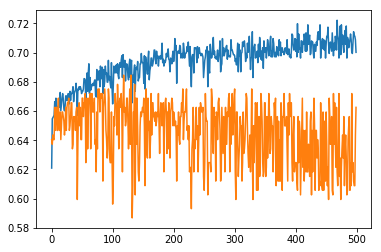

In [113]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

Weights used: {2.0: 4.0, 1.0: 1030.0, 0.0: 557.0}
epoch=0 tscore=0.4003139717425432 vscore=0.36908517350157727
epoch=1 tscore=0.4175824175824176 vscore=0.3785488958990536
epoch=2 tscore=0.4175824175824176 vscore=0.3659305993690852
epoch=3 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=4 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=5 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=6 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=7 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=8 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=9 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=10 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=11 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=12 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=13 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=14 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=15 tscore=0.41601255886970

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


epoch=44 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=45 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=46 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=47 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=48 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=49 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=50 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=51 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=52 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=53 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=54 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=55 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=56 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=57 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=58 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=59 tscore=0.41601255886970173 vscore=0.3659305993690852
epoch=60

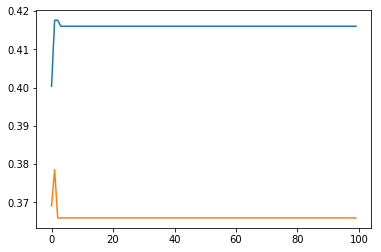

In [114]:
my_lr.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=100,
            penalty="l2", dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, 
            class_weight=None,  solver="newton-cg", max_iter=100, multi_class="multinomial")

(289, 13) (289,)
0.3391003460207612
[0.33910035 0.         0.        ]
1
(289, 13) (289,)
0.6228373702422145
[0.33910035 0.62283737 0.        ]
2
(289, 13) (289,)
0.6124567474048442
[0.33910035 0.62283737 0.61245675]
3


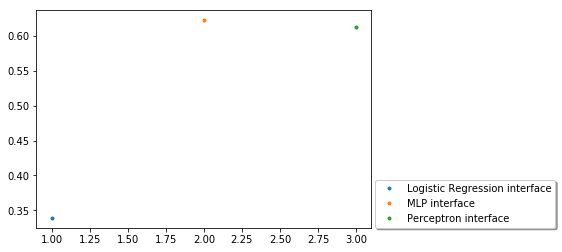

best is MLP interface with score 0.62


In [115]:
test_sup(*data.get_valid(), my_lr, my_MLP, my_perc)

# Data Allowance

In [116]:
#most between 0 and 0.33, cut out outliers and rescale ?
df = df_clean.copy()

X = df[traffic_columns]
y = df['DataAllowance'].map(lambda x: '%.1f'%x, na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1387, test size 249


run=1 tscore=0.33515 vscore=0.353147
run=2 tscore=0.323342 vscore=0.346154
run=3 tscore=0.339691 vscore=0.346154
run=4 tscore=0.319709 vscore=0.318182
run=5 tscore=0.337875 vscore=0.342657
run=6 tscore=0.337875 vscore=0.325175
run=7 tscore=0.343324 vscore=0.339161
run=8 tscore=0.344233 vscore=0.342657
run=9 tscore=0.337875 vscore=0.328671
run=10 tscore=0.341508 vscore=0.321678
run=11 tscore=0.337875 vscore=0.339161
run=12 tscore=0.345141 vscore=0.339161
run=13 tscore=0.337875 vscore=0.339161
run=14 tscore=0.340599 vscore=0.353147
run=15 tscore=0.337875 vscore=0.339161
run=16 tscore=0.343324 vscore=0.34965
run=17 tscore=0.338783 vscore=0.342657
run=18 tscore=0.342416 vscore=0.346154
run=19 tscore=0.341508 vscore=0.346154
run=20 tscore=0.336966 vscore=0.34965
run=21 tscore=0.343324 vscore=0.339161
run=22 tscore=0.340599 vscore=0.34965
run=23 tscore=0.339691 vscore=0.342657
run=24 tscore=0.340599 vscore=0.356643
run=25 tscore=0.338783 vscore=0.346154
run=26 tscore=0.340599 vscore=0.34965


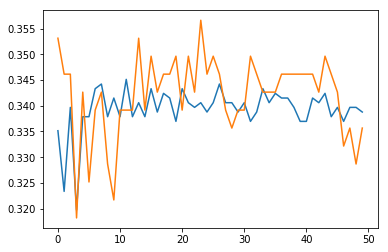

In [117]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

epoch=0 loss=2.307071250577216 tscore=0.23524069028156222 vscore=0.25874125874125875
epoch=1 loss=2.286106670242051 tscore=0.3060853769300636 vscore=0.32167832167832167
epoch=2 loss=2.2669958830272328 tscore=0.3278837420526794 vscore=0.34965034965034963


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=3 loss=2.2493435038245346 tscore=0.33242506811989103 vscore=0.35664335664335667
epoch=4 loss=2.233328234356051 tscore=0.3333333333333333 vscore=0.36013986013986016
epoch=5 loss=2.217837630868123 tscore=0.3333333333333333 vscore=0.36013986013986016
epoch=6 loss=2.202888100482292 tscore=0.335149863760218 vscore=0.36013986013986016
epoch=7 loss=2.187965058248766 tscore=0.33605812897366033 vscore=0.36013986013986016
epoch=8 loss=2.1720778800371403 tscore=0.3369663941871026 vscore=0.36013986013986016
epoch=9 loss=2.156392100692441 tscore=0.3369663941871026 vscore=0.36013986013986016
epoch=10 loss=2.14185338726212 tscore=0.3369663941871026 vscore=0.36013986013986016
epoch=11 loss=2.1280638714481075 tscore=0.3369663941871026 vscore=0.36013986013986016
epoch=12 loss=2.1144132330754095 tscore=0.3369663941871026 vscore=0.36013986013986016
epoch=13 loss=2.099992025447287 tscore=0.3369663941871026 vscore=0.36013986013986016
epoch=14 loss=2.0862774960388037 tscore=0.3369663941871026 vscore=0.

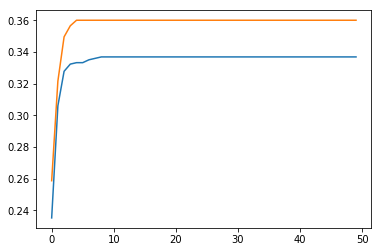

In [118]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,
             hidden_layer_sizes = (400,), batch_size = 100, learning_rate_init=1e-4, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.05, tol = 1e-4)

(249, 13) (249,)
0.42168674698795183
[0.42168675 0.        ]
1
(249, 13) (249,)
0.41365461847389556
[0.42168675 0.41365462]
2


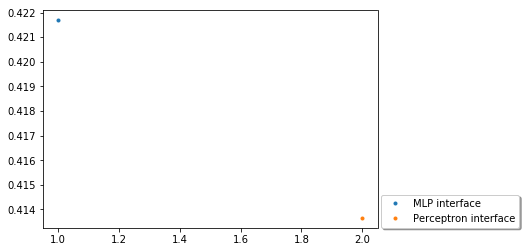

best is MLP interface with score 0.42


In [119]:
test_sup(*data.get_valid(), my_MLP, my_perc)

# Monthly Data Traffic

In [120]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['MonthlyDataTraffic'].map(lambda x: '%.1f'%x, na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1620, test size 297


Weights used: {'0.2': 92.0, '0.0': 1023.0, '0.1': 475.0, '0.5': 3.0, '0.3': 14.0, '0.4': 9.0, '1.0': 2.0, '0.9': 1.0, '0.7': 1.0}
run=1 tscore=0.119938 vscore=0.0803571
run=2 tscore=0.391745 vscore=0.383929
run=3 tscore=0.387072 vscore=0.345238
run=4 tscore=0.412773 vscore=0.407738
run=5 tscore=0.390187 vscore=0.366071
run=6 tscore=0.407321 vscore=0.366071
run=7 tscore=0.422118 vscore=0.410714
run=8 tscore=0.383956 vscore=0.357143
run=9 tscore=0.426012 vscore=0.425595
run=10 tscore=0.428349 vscore=0.425595
run=11 tscore=0.419003 vscore=0.425595
run=12 tscore=0.428349 vscore=0.416667
run=13 tscore=0.419782 vscore=0.416667
run=14 tscore=0.408879 vscore=0.404762
run=15 tscore=0.418224 vscore=0.410714
run=16 tscore=0.425234 vscore=0.422619
run=17 tscore=0.428349 vscore=0.431548
run=18 tscore=0.422118 vscore=0.428571
run=19 tscore=0.429128 vscore=0.425595
run=20 tscore=0.355919 vscore=0.35119
run=21 tscore=0.422897 vscore=0.4375
run=22 tscore=0.425234 vscore=0.431548
run=23 tscore=0.434579 

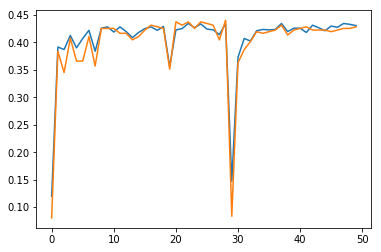

In [121]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

epoch=0 loss=1.291906380475136 tscore=0.6246105919003115 vscore=0.6577380952380952
epoch=1 loss=0.9491170926026508 tscore=0.6246105919003115 vscore=0.6607142857142857
epoch=2 loss=0.9053933713330712 tscore=0.6253894080996885 vscore=0.6636904761904762
epoch=3 loss=0.878877248688663 tscore=0.6246105919003115 vscore=0.6726190476190477
epoch=4 loss=0.8737609898732962 tscore=0.6246105919003115 vscore=0.6666666666666666
epoch=5 loss=0.8658250308985755 tscore=0.6269470404984424 vscore=0.6547619047619048
epoch=6 loss=0.8646829868106635 tscore=0.6253894080996885 vscore=0.6666666666666666
epoch=7 loss=0.8600080742413007 tscore=0.6269470404984424 vscore=0.6607142857142857
epoch=8 loss=0.8548309652157281 tscore=0.6207165109034268 vscore=0.6726190476190477


/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=9 loss=0.8615698249100334 tscore=0.6347352024922118 vscore=0.6636904761904762
epoch=10 loss=0.8539444580038611 tscore=0.6285046728971962 vscore=0.6875
epoch=11 loss=0.8496183657872411 tscore=0.6261682242990654 vscore=0.6577380952380952
epoch=12 loss=0.8461685339484952 tscore=0.6277258566978193 vscore=0.6577380952380952
epoch=13 loss=0.845793532456131 tscore=0.631619937694704 vscore=0.6577380952380952
epoch=14 loss=0.8447276840074347 tscore=0.6300623052959502 vscore=0.6815476190476191
epoch=15 loss=0.8459106701978685 tscore=0.6261682242990654 vscore=0.6577380952380952
epoch=16 loss=0.8489830120254702 tscore=0.631619937694704 vscore=0.6696428571428571
epoch=17 loss=0.8500969950864217 tscore=0.6285046728971962 vscore=0.6547619047619048
epoch=18 loss=0.840332201240167 tscore=0.6277258566978193 vscore=0.6607142857142857
epoch=19 loss=0.8365006541272673 tscore=0.6355140186915887 vscore=0.6607142857142857
epoch=20 loss=0.8409282202063438 tscore=0.6401869158878505 vscore=0.65773809523809

epoch=109 loss=0.8001292211897694 tscore=0.661993769470405 vscore=0.6815476190476191
epoch=110 loss=0.7996675977649851 tscore=0.6612149532710281 vscore=0.6815476190476191
epoch=111 loss=0.7990770827472005 tscore=0.6549844236760125 vscore=0.6934523809523809
epoch=112 loss=0.8011765515134125 tscore=0.6534267912772586 vscore=0.6607142857142857
epoch=113 loss=0.8009208125963343 tscore=0.6674454828660437 vscore=0.6755952380952381
epoch=114 loss=0.7990327564902913 tscore=0.6635514018691588 vscore=0.6666666666666666
epoch=115 loss=0.8075149801910316 tscore=0.6487538940809969 vscore=0.6607142857142857
epoch=116 loss=0.8031275180134608 tscore=0.6580996884735203 vscore=0.6577380952380952
epoch=117 loss=0.7984242354827754 tscore=0.6573208722741433 vscore=0.6964285714285714
epoch=118 loss=0.801963079389504 tscore=0.6627725856697819 vscore=0.6845238095238095
epoch=119 loss=0.8023389144254701 tscore=0.6651090342679128 vscore=0.6607142857142857
epoch=120 loss=0.814454650228765 tscore=0.66433021806853

epoch=208 loss=0.7864674745978838 tscore=0.6721183800623053 vscore=0.6845238095238095
epoch=209 loss=0.7969905978169137 tscore=0.6666666666666666 vscore=0.6815476190476191
epoch=210 loss=0.792727883064307 tscore=0.6690031152647975 vscore=0.6845238095238095
epoch=211 loss=0.7910205954434997 tscore=0.6690031152647975 vscore=0.6815476190476191
epoch=212 loss=0.7997460060998577 tscore=0.6588785046728972 vscore=0.6666666666666666
epoch=213 loss=0.7921266970938804 tscore=0.6721183800623053 vscore=0.6845238095238095
epoch=214 loss=0.7915608778555182 tscore=0.6596573208722741 vscore=0.6636904761904762
epoch=215 loss=0.7868369144449551 tscore=0.6728971962616822 vscore=0.6607142857142857
epoch=216 loss=0.7868500770382475 tscore=0.6744548286604362 vscore=0.6666666666666666
epoch=217 loss=0.7930355593573675 tscore=0.6713395638629284 vscore=0.6726190476190477
epoch=218 loss=0.7872123804880529 tscore=0.6713395638629284 vscore=0.6607142857142857
epoch=219 loss=0.7909726095955114 tscore=0.671339563862

epoch=306 loss=0.7807990132012579 tscore=0.6814641744548287 vscore=0.6785714285714286
epoch=307 loss=0.7829610377224752 tscore=0.676791277258567 vscore=0.6785714285714286
epoch=308 loss=0.7840931757698573 tscore=0.6783489096573209 vscore=0.6755952380952381
epoch=309 loss=0.7808815678801289 tscore=0.6791277258566978 vscore=0.6815476190476191
epoch=310 loss=0.7814744265863827 tscore=0.6799065420560748 vscore=0.6607142857142857
epoch=311 loss=0.7883200350875604 tscore=0.6728971962616822 vscore=0.6815476190476191
epoch=312 loss=0.7979898640629083 tscore=0.6526479750778816 vscore=0.6517857142857143
epoch=313 loss=0.7862812652031376 tscore=0.6721183800623053 vscore=0.6696428571428571
epoch=314 loss=0.7793363903469255 tscore=0.6806853582554517 vscore=0.6666666666666666
epoch=315 loss=0.7820850770842264 tscore=0.67601246105919 vscore=0.6785714285714286
epoch=316 loss=0.7784638602044807 tscore=0.6736760124610592 vscore=0.6845238095238095
epoch=317 loss=0.7840948502656834 tscore=0.67133956386292

epoch=413 loss=0.773587420746248 tscore=0.6799065420560748 vscore=0.6755952380952381
epoch=414 loss=0.776186079269245 tscore=0.6830218068535826 vscore=0.6785714285714286
epoch=415 loss=0.7727176896387747 tscore=0.6799065420560748 vscore=0.6875
epoch=416 loss=0.7792070612522289 tscore=0.6744548286604362 vscore=0.6696428571428571
epoch=417 loss=0.7754432192719547 tscore=0.6814641744548287 vscore=0.6488095238095238
epoch=418 loss=0.7770847536013468 tscore=0.6814641744548287 vscore=0.6785714285714286
epoch=419 loss=0.7720662602274989 tscore=0.6853582554517134 vscore=0.6845238095238095
epoch=420 loss=0.7752750169508735 tscore=0.6791277258566978 vscore=0.6755952380952381
epoch=421 loss=0.7741587116692425 tscore=0.6752336448598131 vscore=0.6755952380952381
epoch=422 loss=0.7774360601512352 tscore=0.6752336448598131 vscore=0.6577380952380952
epoch=423 loss=0.7745238668019032 tscore=0.6674454828660437 vscore=0.6726190476190477
epoch=424 loss=0.7756826070617442 tscore=0.6783489096573209 vscore=0

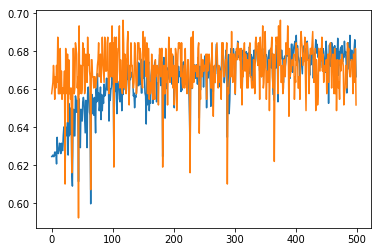

In [122]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

(297, 13) (297,)
0.6902356902356902
[0.69023569 0.        ]
1
(297, 13) (297,)
0.4478114478114478
[0.69023569 0.44781145]
2


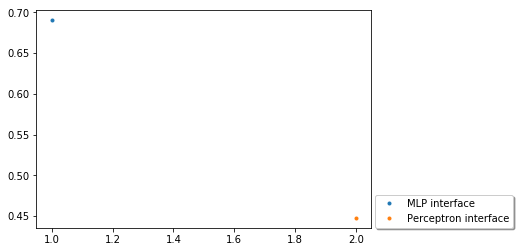

best is MLP interface with score 0.69


In [123]:
test_sup(*data.get_valid(), my_MLP, my_perc)

# Data ARPU

In [124]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['DataArpu'].map(lambda x: '%.1f'%x, na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1270, test size 223


run=1 tscore=0.277445 vscore=0.261194
run=2 tscore=0.452096 vscore=0.402985
run=3 tscore=0.456088 vscore=0.395522
run=4 tscore=0.452096 vscore=0.402985
run=5 tscore=0.453094 vscore=0.399254
run=6 tscore=0.456088 vscore=0.399254
run=7 tscore=0.456088 vscore=0.391791
run=8 tscore=0.456088 vscore=0.380597
run=9 tscore=0.45509 vscore=0.402985
run=10 tscore=0.458084 vscore=0.395522
run=11 tscore=0.453094 vscore=0.38806
run=12 tscore=0.456088 vscore=0.395522
run=13 tscore=0.45509 vscore=0.395522
run=14 tscore=0.45509 vscore=0.38806
run=15 tscore=0.456088 vscore=0.395522
run=16 tscore=0.462076 vscore=0.395522
run=17 tscore=0.456088 vscore=0.395522
run=18 tscore=0.451098 vscore=0.384328
run=19 tscore=0.457086 vscore=0.402985
run=20 tscore=0.457086 vscore=0.399254
run=21 tscore=0.457086 vscore=0.399254
run=22 tscore=0.452096 vscore=0.38806
run=23 tscore=0.459082 vscore=0.402985
run=24 tscore=0.458084 vscore=0.391791
run=25 tscore=0.456088 vscore=0.395522
run=26 tscore=0.458084 vscore=0.402985
r

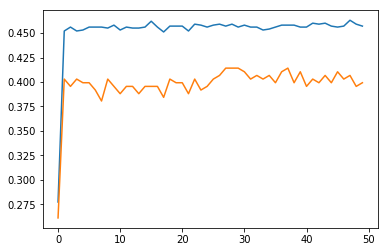

In [125]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=1.744322288530698 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=1 loss=1.3883646458960324 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=2 loss=1.3706931839943122 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=3 loss=1.3667316193682584 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=4 loss=1.3584575800340433 tscore=0.4500998003992016 vscore=0.417910447761194
epoch=5 loss=1.3525671371353647 tscore=0.4540918163672655 vscore=0.39925373134328357
epoch=6 loss=1.3597388879988055 tscore=0.4491017964071856 vscore=0.41044776119402987
epoch=7 loss=1.3609369790191619 tscore=0.4481037924151697 vscore=0.4141791044776119
epoch=8 loss=1.3471079733758398 tscore=0.46407185628742514 vscore=0.3843283582089552
epoch=9 loss=1.3439641445611932 tscore=0.4471057884231537 vscore=0.4141791044776119
epoch=10 loss=1.3628362340382887 tscore=0.4540918163672655 vscore=0.40671641791044777
epoch=11 loss=1.345592010120741 tscore=0.4500998003992016 vscore=0.4104477611

epoch=101 loss=1.3309566327942173 tscore=0.4600798403193613 vscore=0.3917910447761194
epoch=102 loss=1.3453048270058972 tscore=0.46706586826347307 vscore=0.3843283582089552
epoch=103 loss=1.3422268595468858 tscore=0.4491017964071856 vscore=0.41044776119402987
epoch=104 loss=1.3395141130270702 tscore=0.4630738522954092 vscore=0.3843283582089552
epoch=105 loss=1.3340783719571327 tscore=0.4550898203592814 vscore=0.39552238805970147
epoch=106 loss=1.3440831854470248 tscore=0.4560878243512974 vscore=0.3843283582089552
epoch=107 loss=1.342331974637363 tscore=0.4481037924151697 vscore=0.41044776119402987
epoch=108 loss=1.3443577531397988 tscore=0.41916167664670656 vscore=0.35447761194029853
epoch=109 loss=1.3337792373928652 tscore=0.45109780439121755 vscore=0.41044776119402987
epoch=110 loss=1.3326193309453214 tscore=0.46506986027944114 vscore=0.3880597014925373
epoch=111 loss=1.3426452021837838 tscore=0.468063872255489 vscore=0.3805970149253731
epoch=112 loss=1.3330594696824638 tscore=0.4560

epoch=206 loss=1.3253995909691516 tscore=0.47005988023952094 vscore=0.3805970149253731
epoch=207 loss=1.3272727497275212 tscore=0.4630738522954092 vscore=0.376865671641791
epoch=208 loss=1.3266881276728448 tscore=0.4550898203592814 vscore=0.3880597014925373
epoch=209 loss=1.33035414274989 tscore=0.46407185628742514 vscore=0.40671641791044777
epoch=210 loss=1.327347533571683 tscore=0.4630738522954092 vscore=0.3694029850746269
epoch=211 loss=1.335472507715534 tscore=0.4620758483033932 vscore=0.3619402985074627
epoch=212 loss=1.3270853020266606 tscore=0.4560878243512974 vscore=0.40671641791044777
epoch=213 loss=1.3334149005375306 tscore=0.4550898203592814 vscore=0.3917910447761194
epoch=214 loss=1.3294003719449294 tscore=0.4600798403193613 vscore=0.3843283582089552
epoch=215 loss=1.3299508317807867 tscore=0.46706586826347307 vscore=0.3805970149253731
epoch=216 loss=1.3262035742412028 tscore=0.4630738522954092 vscore=0.39925373134328357
epoch=217 loss=1.3260466926360281 tscore=0.4600798403

epoch=301 loss=1.3206087695035256 tscore=0.45808383233532934 vscore=0.39552238805970147
epoch=302 loss=1.3209519120994313 tscore=0.4560878243512974 vscore=0.39552238805970147
epoch=303 loss=1.3309618774622092 tscore=0.469061876247505 vscore=0.3656716417910448
epoch=304 loss=1.3372208157552132 tscore=0.46706586826347307 vscore=0.3656716417910448
epoch=305 loss=1.327667893321154 tscore=0.468063872255489 vscore=0.3805970149253731
epoch=306 loss=1.3212963433112408 tscore=0.46706586826347307 vscore=0.3805970149253731
epoch=307 loss=1.3248168357707193 tscore=0.4630738522954092 vscore=0.3619402985074627
epoch=308 loss=1.320697853521142 tscore=0.46107784431137727 vscore=0.4141791044776119
epoch=309 loss=1.3212509739691987 tscore=0.4600798403193613 vscore=0.40298507462686567
epoch=310 loss=1.318710988639481 tscore=0.4600798403193613 vscore=0.3917910447761194
epoch=311 loss=1.3198696837114499 tscore=0.4590818363273453 vscore=0.40298507462686567
epoch=312 loss=1.3222337024150494 tscore=0.44111776

epoch=402 loss=1.3190164862503932 tscore=0.4630738522954092 vscore=0.3843283582089552
epoch=403 loss=1.321183134777978 tscore=0.47704590818363274 vscore=0.3805970149253731
epoch=404 loss=1.3169985631085515 tscore=0.4740518962075848 vscore=0.39552238805970147
epoch=405 loss=1.320027828913418 tscore=0.468063872255489 vscore=0.39552238805970147
epoch=406 loss=1.3194845332159306 tscore=0.4780439121756487 vscore=0.39552238805970147
epoch=407 loss=1.318736156856728 tscore=0.4810379241516966 vscore=0.39552238805970147
epoch=408 loss=1.3172691435725554 tscore=0.47904191616766467 vscore=0.39552238805970147
epoch=409 loss=1.3170549795436408 tscore=0.4780439121756487 vscore=0.3917910447761194
epoch=410 loss=1.3161030697233669 tscore=0.46407185628742514 vscore=0.39925373134328357
epoch=411 loss=1.3201806319012133 tscore=0.4630738522954092 vscore=0.39925373134328357
epoch=412 loss=1.3200295550107097 tscore=0.437125748502994 vscore=0.3880597014925373
epoch=413 loss=1.327181822651645 tscore=0.4700598

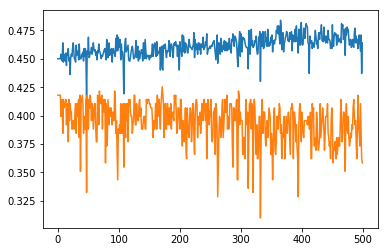

In [126]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

(223, 13) (223,)
0.4663677130044843
[0.46636771 0.        ]
1
(223, 13) (223,)
0.5112107623318386
[0.46636771 0.51121076]
2


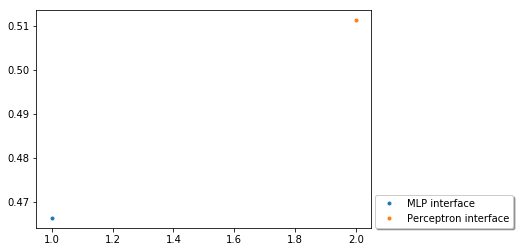

best is Perceptron interface with score 0.51


In [127]:
test_sup(*data.get_valid(), my_MLP, my_perc)

# Monthly Voice Traffic Count

In [128]:
df = df_clean.copy()

X = df[traffic_columns]
y = df['MonthlyVoiceTrafficCount'].map(lambda x: '%.1f'%x, na_action = 'ignore')
data = buildTrain(X, y, perc=0.85)
print('train size %d, test size %d' % (data.get_size()))
build_seed = 4562
my_perc = perc(build_seed)
my_MLP = MLP(build_seed)
my_lr = LogReg(build_seed)

train size 1614, test size 303


run=1 tscore=0.336463 vscore=0.330357
run=2 tscore=0.43662 vscore=0.369048
run=3 tscore=0.43975 vscore=0.372024
run=4 tscore=0.438185 vscore=0.366071
run=5 tscore=0.438967 vscore=0.366071
run=6 tscore=0.456182 vscore=0.372024
run=7 tscore=0.441315 vscore=0.357143
run=8 tscore=0.437402 vscore=0.360119
run=9 tscore=0.449922 vscore=0.383929
run=10 tscore=0.441315 vscore=0.357143
run=11 tscore=0.460876 vscore=0.372024
run=12 tscore=0.466354 vscore=0.377976
run=13 tscore=0.444444 vscore=0.35119
run=14 tscore=0.467136 vscore=0.375
run=15 tscore=0.43975 vscore=0.360119
run=16 tscore=0.449922 vscore=0.363095
run=17 tscore=0.444444 vscore=0.35119
run=18 tscore=0.443662 vscore=0.363095
run=19 tscore=0.449922 vscore=0.363095
run=20 tscore=0.443662 vscore=0.363095
run=21 tscore=0.468701 vscore=0.375
run=22 tscore=0.456182 vscore=0.369048
run=23 tscore=0.444444 vscore=0.360119
run=24 tscore=0.447574 vscore=0.360119
run=25 tscore=0.463224 vscore=0.377976
run=26 tscore=0.438967 vscore=0.345238
run=27

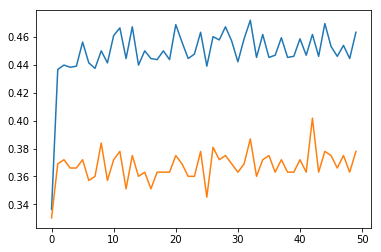

In [129]:
my_perc.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=50,  
              loss='log', penalty='none', alpha=1e-8, power_t=0.7, it_interval=100, learning_rate='invscaling', 
              eta0=1e4, class_weight=None)

/Users/Renato/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


epoch=0 loss=1.5652085804950153 tscore=0.486697965571205 vscore=0.4375
epoch=1 loss=1.3144318718163228 tscore=0.4694835680751174 vscore=0.42857142857142855
epoch=2 loss=1.2901005472940703 tscore=0.4702660406885759 vscore=0.41964285714285715
epoch=3 loss=1.2799780571294093 tscore=0.48826291079812206 vscore=0.42857142857142855
epoch=4 loss=1.272048348221048 tscore=0.47417840375586856 vscore=0.40773809523809523
epoch=5 loss=1.2648469490863463 tscore=0.48043818466353677 vscore=0.4166666666666667
epoch=6 loss=1.2675127028756548 tscore=0.48826291079812206 vscore=0.43154761904761907
epoch=7 loss=1.2618387378614926 tscore=0.4921752738654147 vscore=0.42857142857142855
epoch=8 loss=1.2479024812661381 tscore=0.48826291079812206 vscore=0.4226190476190476
epoch=9 loss=1.2459981886839435 tscore=0.49139280125195617 vscore=0.4226190476190476
epoch=10 loss=1.2433008580669755 tscore=0.48826291079812206 vscore=0.4255952380952381
epoch=11 loss=1.2459351754117998 tscore=0.4921752738654147 vscore=0.42559523

epoch=102 loss=1.1815343096102622 tscore=0.5352112676056338 vscore=0.43452380952380953
epoch=103 loss=1.177216737541027 tscore=0.528169014084507 vscore=0.4583333333333333
epoch=104 loss=1.1753266790019976 tscore=0.5422535211267606 vscore=0.4375
epoch=105 loss=1.1731182607268797 tscore=0.528169014084507 vscore=0.46726190476190477
epoch=106 loss=1.181440494181405 tscore=0.52660406885759 vscore=0.4494047619047619
epoch=107 loss=1.1778550558123226 tscore=0.5242566510172144 vscore=0.4375
epoch=108 loss=1.1706784529072138 tscore=0.5273865414710485 vscore=0.45535714285714285
epoch=109 loss=1.1707879462170907 tscore=0.5367762128325508 vscore=0.4642857142857143
epoch=110 loss=1.1737194679706011 tscore=0.5453834115805947 vscore=0.4375
epoch=111 loss=1.1751950168788519 tscore=0.5406885758998435 vscore=0.4375
epoch=112 loss=1.172126024856727 tscore=0.539906103286385 vscore=0.44047619047619047
epoch=113 loss=1.1720120687171673 tscore=0.5297339593114241 vscore=0.4523809523809524
epoch=114 loss=1.164

epoch=199 loss=1.1524542918366245 tscore=0.5610328638497653 vscore=0.4494047619047619
epoch=200 loss=1.150848124661496 tscore=0.5500782472613458 vscore=0.43154761904761907
epoch=201 loss=1.1485181851995419 tscore=0.5579029733959311 vscore=0.46130952380952384
epoch=202 loss=1.1522364982672209 tscore=0.5672926447574335 vscore=0.4375
epoch=203 loss=1.1536827271545673 tscore=0.5579029733959311 vscore=0.45535714285714285
epoch=204 loss=1.145290469955495 tscore=0.5563380281690141 vscore=0.44047619047619047
epoch=205 loss=1.1532956901885572 tscore=0.5586854460093896 vscore=0.44642857142857145
epoch=206 loss=1.1505790267870064 tscore=0.5688575899843505 vscore=0.4494047619047619
epoch=207 loss=1.1557193977817777 tscore=0.554773082942097 vscore=0.4494047619047619
epoch=208 loss=1.1506340245128397 tscore=0.5657276995305164 vscore=0.44047619047619047
epoch=209 loss=1.1465601437514918 tscore=0.5453834115805947 vscore=0.44642857142857145
epoch=210 loss=1.1581305906565087 tscore=0.5477308294209703 vs

epoch=301 loss=1.139472739211561 tscore=0.5719874804381847 vscore=0.4523809523809524
epoch=302 loss=1.1414945038859532 tscore=0.5782472613458529 vscore=0.43154761904761907
epoch=303 loss=1.1302542063343841 tscore=0.5758998435054773 vscore=0.45535714285714285
epoch=304 loss=1.1366015704279748 tscore=0.5845070422535211 vscore=0.46130952380952384
epoch=305 loss=1.1321977052496932 tscore=0.5774647887323944 vscore=0.45535714285714285
epoch=306 loss=1.1304635541478993 tscore=0.5719874804381847 vscore=0.4375
epoch=307 loss=1.1284129256865227 tscore=0.5758998435054773 vscore=0.44047619047619047
epoch=308 loss=1.130016195029416 tscore=0.5892018779342723 vscore=0.4642857142857143
epoch=309 loss=1.130853254834344 tscore=0.5727699530516432 vscore=0.4494047619047619
epoch=310 loss=1.1326374867164524 tscore=0.5845070422535211 vscore=0.45535714285714285
epoch=311 loss=1.130904656587975 tscore=0.5790297339593115 vscore=0.4583333333333333
epoch=312 loss=1.140377510173845 tscore=0.5852895148669797 vscor

epoch=399 loss=1.116987587364285 tscore=0.5954616588419406 vscore=0.46726190476190477
epoch=400 loss=1.1200654291361747 tscore=0.5868544600938967 vscore=0.4375
epoch=401 loss=1.1207221445230235 tscore=0.5837245696400626 vscore=0.45535714285714285
epoch=402 loss=1.1327176285487963 tscore=0.5868544600938967 vscore=0.45535714285714285
epoch=403 loss=1.1228477337994291 tscore=0.5758998435054773 vscore=0.41369047619047616
epoch=404 loss=1.1209452762106134 tscore=0.5899843505477308 vscore=0.45535714285714285
epoch=405 loss=1.1252048886739179 tscore=0.5978090766823161 vscore=0.4583333333333333
epoch=406 loss=1.1193305193534986 tscore=0.57981220657277 vscore=0.4494047619047619
epoch=407 loss=1.1249289848749824 tscore=0.581377151799687 vscore=0.4375
epoch=408 loss=1.1358092469938588 tscore=0.593114241001565 vscore=0.44047619047619047
epoch=409 loss=1.120070898260584 tscore=0.594679186228482 vscore=0.4583333333333333
epoch=410 loss=1.1232281418793608 tscore=0.5751173708920188 vscore=0.4464285714

epoch=498 loss=1.1122628204142235 tscore=0.5970266040688575 vscore=0.44047619047619047
epoch=499 loss=1.1068065777161675 tscore=0.5907668231611893 vscore=0.4583333333333333


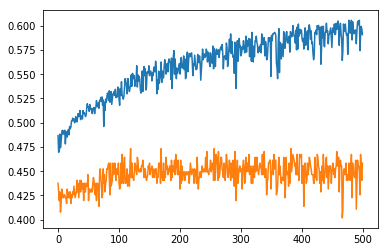

In [130]:
my_MLP.train(*data.get_train(), percentage=0.8, std=False, pca=0, threshold_unbalanced=0.6, epochs=500,
             hidden_layer_sizes = (200,), batch_size = 100, learning_rate_init=1e-2, solver = 'adam', 
             learning_rate = 'constant', momentum = 0.5, nesterovs_momentum = False,
             alpha = 0.01, tol = 1e-4)

(303, 13) (303,)
0.44884488448844884
[0.44884488 0.        ]
1
(303, 13) (303,)
0.47854785478547857
[0.44884488 0.47854785]
2


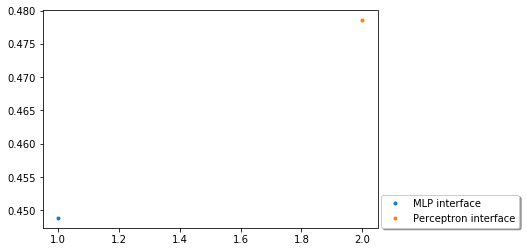

best is Perceptron interface with score 0.48


In [131]:
test_sup(*data.get_valid(), my_MLP, my_perc)